Loaded cleaned dataset: (97629, 41)
RandomForest -> MAE: 4.63, RMSE: 6.44
XGBoost -> MAE: 4.73, RMSE: 6.35
Ensemble -> MAE: 4.60, RMSE: 6.28


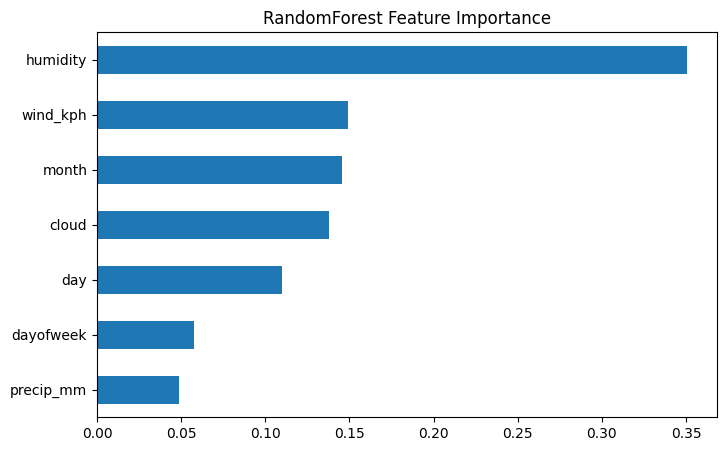

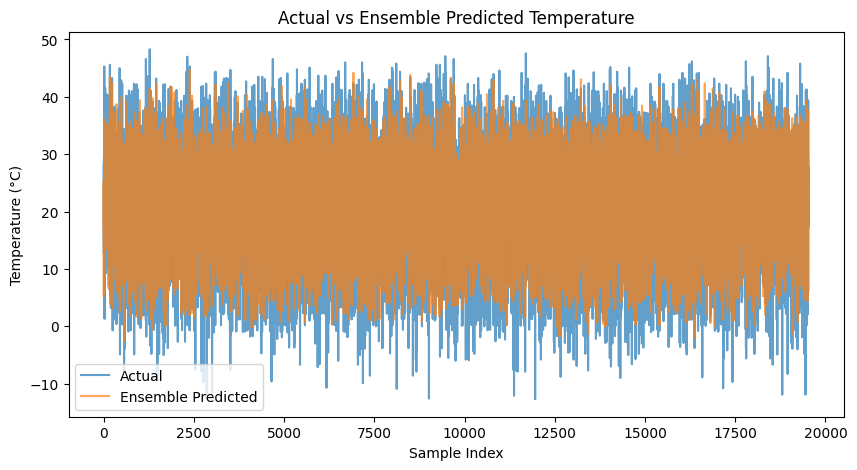

In [1]:
# ============================================================
# Weather Trend Forecasting: 04 Forecasting Models (Updated)
# ============================================================

# ---------------------------
# Step 0: Imports & Setup
# ---------------------------
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime

# Project root & figures folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
figures_dir = os.path.join(project_root, "reports", "figures")
os.makedirs(figures_dir, exist_ok=True)

# ---------------------------
# Step 1: Load cleaned data
# ---------------------------
cleaned_csv_path = os.path.join(project_root, "data", "processed", "weather_cleaned.csv")
df = pd.read_csv(cleaned_csv_path)
df["last_updated"] = pd.to_datetime(df["last_updated"])
print(f"Loaded cleaned dataset: {df.shape}")

# ---------------------------
# Step 2: Feature Engineering (time-based)
# ---------------------------
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df['dayofweek'] = df['last_updated'].dt.dayofweek

# Features for modeling
features = ['humidity','precip_mm','wind_kph','cloud','month','day','dayofweek']
df_model = df.dropna(subset=features + ['temperature_celsius'])
X = df_model[features]
y = df_model['temperature_celsius']

# ---------------------------
# Step 3: Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# Step 4: RandomForest Model
# ---------------------------
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ---------------------------
# Step 5: XGBoost Model
# ---------------------------
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# ---------------------------
# Step 6: Ensemble Predictions
# ---------------------------
y_pred_ensemble = (y_pred_rf + y_pred_xgb)/2

# ---------------------------
# Step 7: Evaluate Models
# ---------------------------
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate_model(y_test, y_pred_rf, "RandomForest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_ensemble, "Ensemble")

# ---------------------------
# Step 8: Feature Importance (RandomForest)
# ---------------------------
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8,5))
importances.sort_values().plot(kind='barh', title="RandomForest Feature Importance")
fig_path = os.path.join(figures_dir, "feature_importance_rf.png")
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

# ---------------------------
# Step 9: Actual vs Predicted Plot
# ---------------------------
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.plot(range(len(y_pred_ensemble)), y_pred_ensemble, label='Ensemble Predicted', alpha=0.7)
plt.title("Actual vs Ensemble Predicted Temperature")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
fig_path = os.path.join(figures_dir, "actual_vs_ensemble_predicted.png")
plt.savefig(fig_path, bbox_inches='tight')
plt.show()
